# Data import

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None) # Show all the columns
df = pd.read_csv('/content/readyformodel_V2.1.csv')
df.head()

,won,pim,powerPlayGoals,faceOffWinPercentage,shots,goals,takeaways,hits,blockedShots,giveaways,missedShots,penalties,timeOnIce,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,hoa_away,hoa_home,settledIn_OT,settledIn_REG,startRinkSide_left,startRinkSide_right,goalieReplacement_No,goalieReplacement_Yes
0,0,2.00,1.0,50.9,8.0,0.0,1.0,14.0,3.0,6.0,4.0,1.0,330.28,280.46,18.52,31.30,1,0,0,1,1,0,0,1
1,1,2.67,1.0,49.1,8.0,3.0,3.0,5.0,3.0,7.0,0.0,1.0,327.11,278.93,25.04,23.15,0,1,0,1,1,0,1,0
2,1,2.00,0.0,43.8,11.0,0.0,0.0,4.0,6.0,2.0,6.0,1.0,334.07,293.20,9.48,31.39,1,0,1,0,0,1,1,0
3,0,2.67,0.0,56.2,12.0,1.0,2.0,4.0,8.0,0.0,3.0,3.0,333.07,296.11,25.11,11.85,0,1,1,0,0,1,1,0
4,1,3.00,0.0,45.7,9.0,0.0,3.0,4.0,7.0,7.0,3.0,2.0,328.89,281.57,17.78,29.54,1,0,0,1,1,0,1,0


# CausalML

## Import packages

In [3]:
!pip install causalml
import scipy.stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier


from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor
from causalml.inference.meta import BaseSRegressor

import shap
import matplotlib.pyplot as plt

import time
from causalml.metrics import *
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import causalml
print(causalml.__version__)

0.12.2


In [5]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.0.2


## Identify treatment, x, y variables

In [6]:
# Target variable (y)
y = df['won']

In [7]:
# Control variables (X)
X = df.copy()
X = X.drop(columns = ['won', 'hoa_home'])
X

,pim,powerPlayGoals,faceOffWinPercentage,shots,goals,takeaways,hits,blockedShots,giveaways,missedShots,penalties,timeOnIce,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,hoa_away,settledIn_OT,settledIn_REG,startRinkSide_left,startRinkSide_right,goalieReplacement_No,goalieReplacement_Yes
0,2.00,1.0,50.9,8.0,0.0,1.0,14.0,3.0,6.0,4.0,1.0,330.28,280.46,18.52,31.30,1,0,1,1,0,0,1
1,2.67,1.0,49.1,8.0,3.0,3.0,5.0,3.0,7.0,0.0,1.0,327.11,278.93,25.04,23.15,0,0,1,1,0,1,0
2,2.00,0.0,43.8,11.0,0.0,0.0,4.0,6.0,2.0,6.0,1.0,334.07,293.20,9.48,31.39,1,1,0,0,1,1,0
3,2.67,0.0,56.2,12.0,1.0,2.0,4.0,8.0,0.0,3.0,3.0,333.07,296.11,25.11,11.85,0,1,0,0,1,1,0
4,3.00,0.0,45.7,9.0,0.0,3.0,4.0,7.0,7.0,3.0,2.0,328.89,281.57,17.78,29.54,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51552,6.67,0.0,58.7,18.0,0.0,12.0,18.0,8.0,8.0,10.0,4.0,330.94,272.09,14.41,44.44,0,0,1,0,1,1,0
51553,0.67,0.0,49.0,4.0,4.0,4.0,28.0,18.0,0.0,4.0,2.0,331.11,322.22,8.89,0.00,1,0,1,0,1,1,0
51554,0.00,0.0,51.0,24.0,0.0,10.0,22.0,4.0,10.0,2.0,0.0,337.15,326.04,0.00,11.11,0,0,1,0,1,1,0
51555,0.67,0.0,49.0,4.0,4.0,4.0,28.0,18.0,0.0,4.0,2.0,331.11,322.22,8.89,0.00,1,0,1,0,1,1,0


In [8]:
# Define a function that will label for treatment
def treat(df):
    if df['hoa_home'] == 1:
        return 1
    return 0
df['Treatment'] = df.apply(lambda df: treat(df), axis=1)

# define treatment
treatment = df['Treatment']

In [9]:
# Propensity calculation
n_wins = len(df[df["won"]==1])
n_treated_H = len(df[(df["won"]==1) & (df["Treatment"]==1)])
e_wins = n_treated_H/n_wins

n_loses = len(df[df["won"]==0])
n_treated_A = len(df[(df["won"]==0) & (df["Treatment"]==0)])
e_loses = n_treated_A/n_loses

df["propensity"] = df["won"]*e_wins + (1-df["won"])*e_loses
df["propensity"].value_counts()

0.547240    26376
0.547834    25181
Name: propensity, dtype: int64

In [10]:
df.Treatment = df.Treatment.replace({1:"treatment_A",0:"control"})
df.Treatment

0            control
1        treatment_A
2            control
3        treatment_A
4            control
            ...     
51552    treatment_A
51553        control
51554    treatment_A
51555        control
51556    treatment_A
Name: Treatment, Length: 51557, dtype: object

In [11]:
# w_multi
w_multi = df.Treatment

In [12]:
# Feature name
feature_names = []
for col in X.columns:
    feature_names.append(col)
feature_names

['pim',
 'powerPlayGoals',
 'faceOffWinPercentage',
 'shots',
 'goals',
 'takeaways',
 'hits',
 'blockedShots',
 'giveaways',
 'missedShots',
 'penalties',
 'timeOnIce',
 'evenTimeOnIce',
 'shortHandedTimeOnIce',
 'powerPlayTimeOnIce',
 'hoa_away',
 'settledIn_OT',
 'settledIn_REG',
 'startRinkSide_left',
 'startRinkSide_right',
 'goalieReplacement_No',
 'goalieReplacement_Yes']

## Modelling

### LRSRegressor with SLearner, "auto" method

In [13]:
# SLearner & Auto
# Ready-to-use S-Learner using LinearRegression
# Implementing S Learner 
base_algo = LGBMRegressor()
slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.05487153])

In [14]:
# Implementing Prediction based on model
slearner_tau = slearner.fit_predict(X, w_multi, y)

In [15]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': timeOnIce                0.452153
 pim                      0.130331
 goals                    0.101308
 goalieReplacement_No     0.060621
 shortHandedTimeOnIce     0.051885
 powerPlayTimeOnIce       0.051859
 powerPlayGoals           0.049997
 settledIn_OT             0.031367
 hits                     0.023479
 penalties                0.013570
 evenTimeOnIce            0.011443
 faceOffWinPercentage     0.005700
 giveaways                0.004771
 takeaways                0.004422
 blockedShots             0.003335
 shots                    0.002300
 missedShots              0.000538
 startRinkSide_left       0.000511
 goalieReplacement_Yes    0.000411
 hoa_away                 0.000000
 settledIn_REG            0.000000
 startRinkSide_right      0.000000
 dtype: float64}

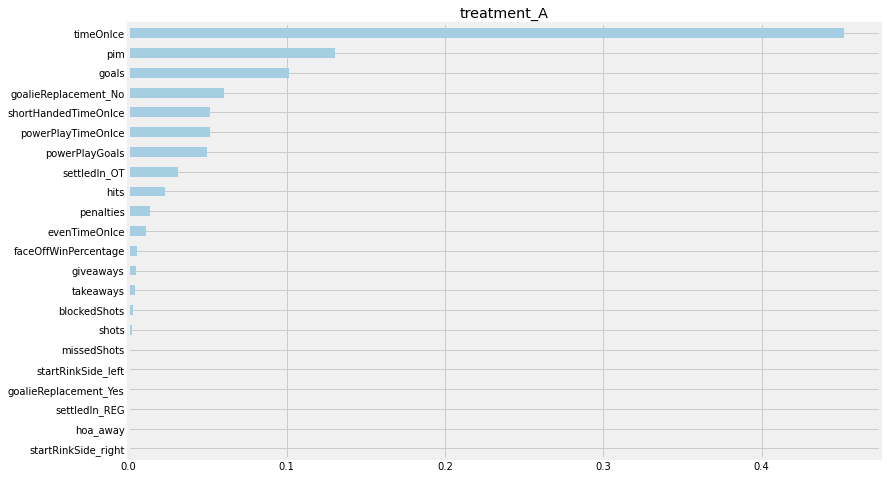

In [16]:
# Auto feature importance plot from Github example.
slearner.plot_importance(X=X,
                        tau=slearner_tau,
                        normalize = True,
                        method = 'auto',
                        features = feature_names)

### LRSRegressor with SLearner, "permutation" method

In [17]:
# Permutation method
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': timeOnIce                0.729939
 pim                      0.317809
 goals                    0.253414
 settledIn_OT             0.150585
 goalieReplacement_No     0.136121
 shortHandedTimeOnIce     0.113340
 powerPlayGoals           0.099970
 powerPlayTimeOnIce       0.094785
 hits                     0.043961
 penalties                0.032318
 evenTimeOnIce            0.021156
 faceOffWinPercentage     0.008679
 blockedShots             0.006754
 giveaways                0.006610
 takeaways                0.005790
 shots                    0.002989
 settledIn_REG            0.001152
 startRinkSide_left       0.000654
 missedShots              0.000436
 hoa_away                 0.000006
 startRinkSide_right      0.000000
 goalieReplacement_Yes    0.000000
 dtype: float64}

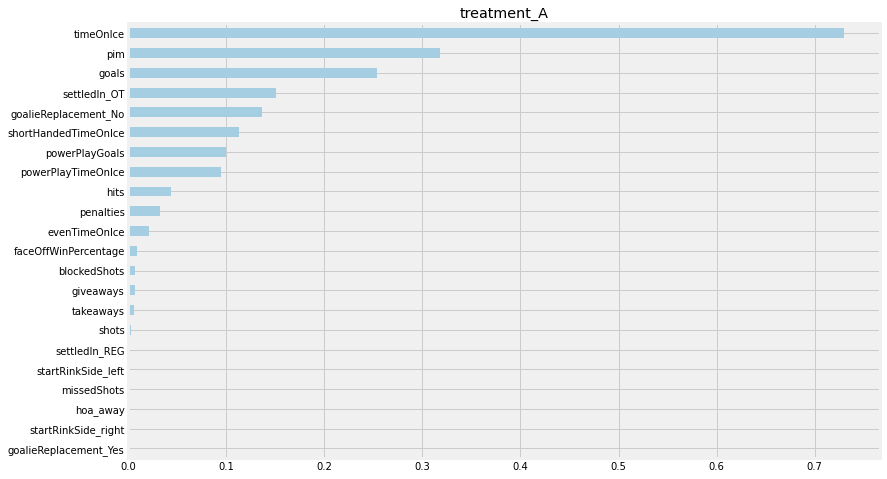

In [18]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### LRSRegressor with SLearner, Shapley Values

In [19]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[-9.04950843e-03,  3.77681293e-04, -5.73475649e-05, ...,
          0.00000000e+00, -9.28469923e-03, -1.07613674e-04],
        [-3.06683300e-03, -3.47123915e-03,  3.07167718e-04, ...,
          0.00000000e+00,  1.05446129e-03,  1.24016485e-05],
        [-1.09673200e-02,  8.48008285e-04, -1.23761160e-03, ...,
          0.00000000e+00,  1.26283139e-03,  1.37468830e-05],
        ...,
        [-9.49303266e-05,  1.08917935e-03, -8.08220343e-05, ...,
          0.00000000e+00,  1.33947992e-03,  2.17833217e-05],
        [ 8.45370620e-03, -2.51361921e-04,  1.53136683e-03, ...,
          0.00000000e+00,  2.07547341e-03,  1.04918220e-05],
        [-9.49303266e-05,  1.08917935e-03, -8.08220343e-05, ...,
          0.00000000e+00,  1.33947992e-03,  2.17833217e-05]])}

In [20]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([1.07375887e-02, 3.56907646e-03, 5.26044639e-04, 5.86022468e-04,
       8.22771476e-03, 2.82023888e-04, 3.48659082e-03, 4.87980292e-04,
       1.00125724e-03, 7.83596554e-05, 2.38520208e-03, 2.11505485e-02,
       2.39456055e-03, 3.37067391e-03, 5.24258270e-03, 0.00000000e+00,
       4.85417864e-03, 0.00000000e+00, 1.60439016e-04, 0.00000000e+00,
       4.58906781e-03, 5.44881430e-05])

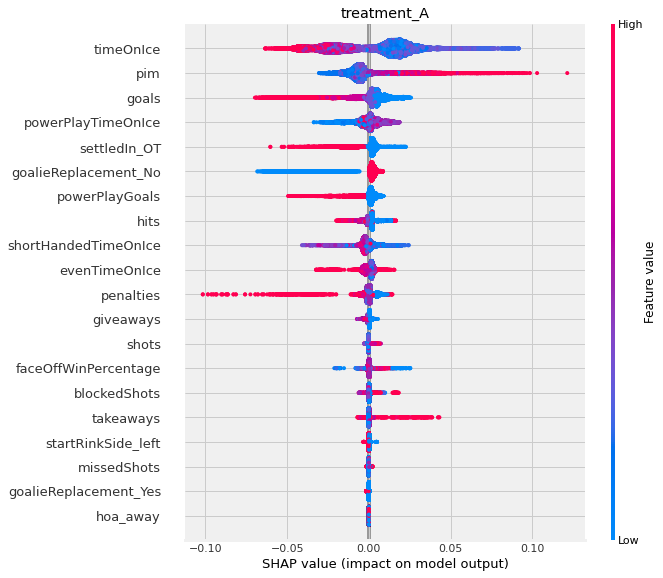

In [21]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

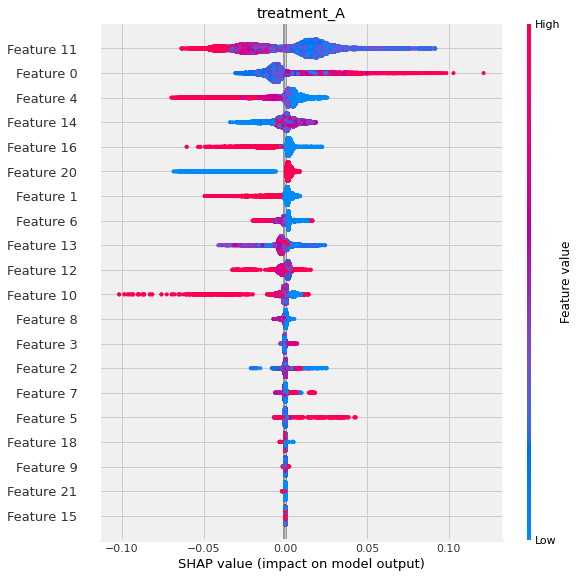

In [22]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

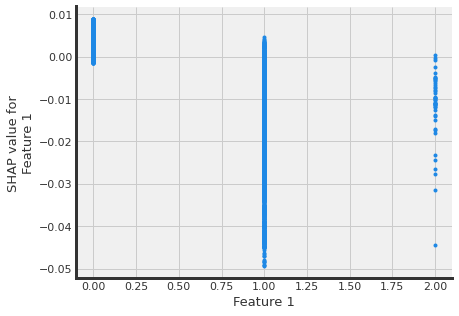

In [23]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

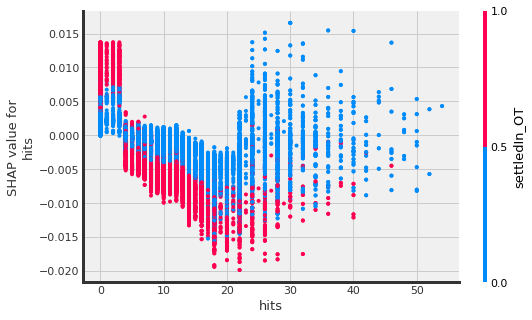

In [24]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=6,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

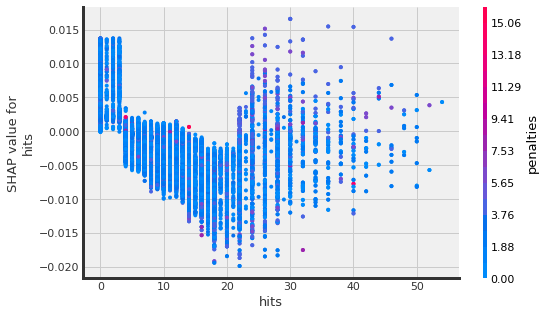

In [25]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=6,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

### LRSRegressor with TLearner, "auto" method

In [26]:
learner_t = LRSRegressor()
cate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print(cate_t)
print('ATE estimate: {:.03f}'.format(cate_t[0][0]))
print('ATE lower bound: {:.03f}'.format(cate_t[1][0]))
print('ATE upper bound: {:.03f}'.format(cate_t[2][0]))

tlearner_tau = learner_t.fit_predict(X, treatment, y)

(array([-1.31629978]), array([-1.75922237]), array([-0.87337719]))
ATE estimate: -1.316
ATE lower bound: -1.759
ATE upper bound: -0.873


In [27]:
learner_t.get_importance(X=X, 
                         tau=tlearner_tau,
                         normalize=True, 
                         method='auto',
                         features = feature_names)

{1: faceOffWinPercentage     1.0
 pim                      0.0
 evenTimeOnIce            0.0
 goalieReplacement_No     0.0
 startRinkSide_right      0.0
 startRinkSide_left       0.0
 settledIn_REG            0.0
 settledIn_OT             0.0
 hoa_away                 0.0
 powerPlayTimeOnIce       0.0
 shortHandedTimeOnIce     0.0
 timeOnIce                0.0
 powerPlayGoals           0.0
 penalties                0.0
 missedShots              0.0
 giveaways                0.0
 blockedShots             0.0
 hits                     0.0
 takeaways                0.0
 goals                    0.0
 shots                    0.0
 goalieReplacement_Yes    0.0
 dtype: float64}

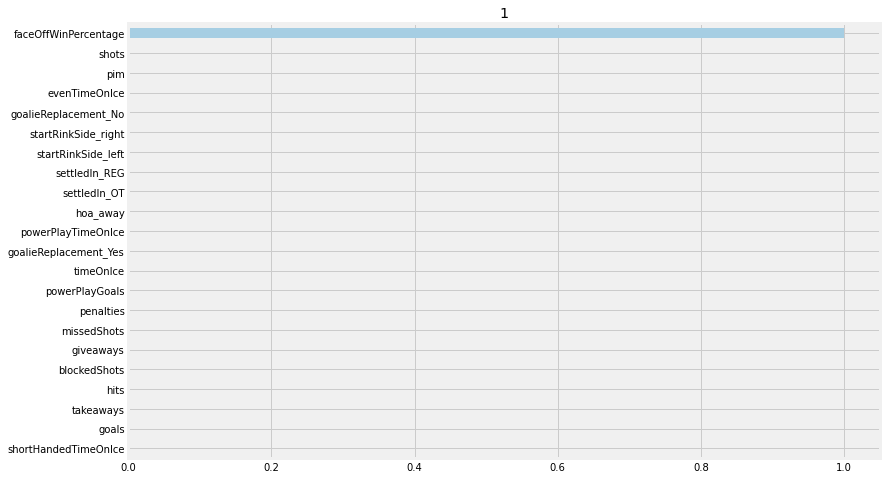

In [28]:
learner_t.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### XGBTRegressor with TLearner, "auto" method

In [29]:
# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

[02:16:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the ready-to-use XGBTRegressor class
(array([0.06559233]), array([0.05833866]), array([0.07284601]))


In [30]:
learner_t.get_importance(X=X, 
                        tau=cate_t,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{1: timeOnIce                0.439668
 pim                      0.156851
 goals                    0.112546
 shortHandedTimeOnIce     0.052364
 powerPlayTimeOnIce       0.045622
 goalieReplacement_No     0.044032
 powerPlayGoals           0.041797
 settledIn_OT             0.037183
 evenTimeOnIce            0.021360
 penalties                0.017472
 hits                     0.009164
 faceOffWinPercentage     0.006395
 blockedShots             0.004417
 missedShots              0.003784
 giveaways                0.003199
 shots                    0.002896
 takeaways                0.000835
 startRinkSide_left       0.000185
 settledIn_REG            0.000163
 hoa_away                 0.000067
 startRinkSide_right      0.000000
 goalieReplacement_Yes    0.000000
 dtype: float64}

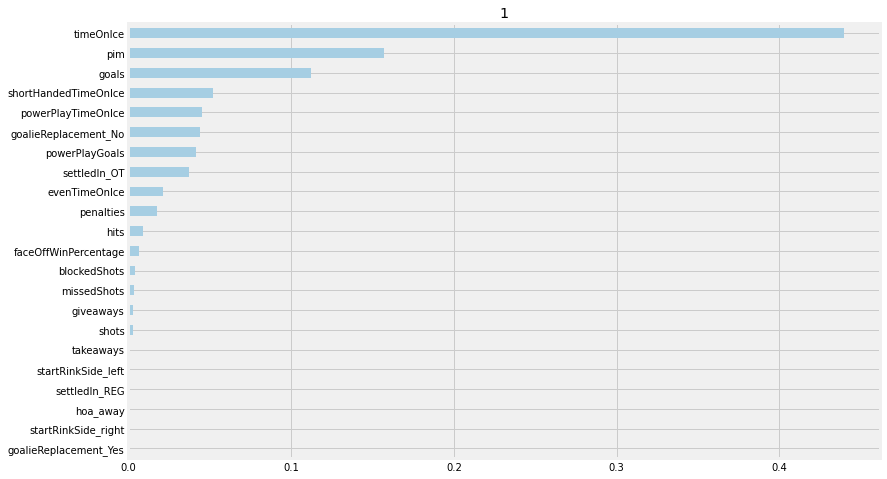

In [31]:
learner_t.plot_importance(X=X, 
                         tau=cate_t, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### XGBTRegressor with X Learner with propensity score input

In [32]:
# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
e = df.propensity
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y,p=e)
print('Using the BaseXRegressor class and using XGB:')
print(cate_x)

[02:16:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB:
[[0.0374374 ]
 [0.08051749]
 [0.01112615]
 ...
 [0.03127507]
 [0.04285174]
 [0.03127507]]


### XGBTRegressor with R Learner with propensity score input 

In [33]:
# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y,p=e)

[02:17:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### A distribution plot of different learners of XGBTRegressor

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


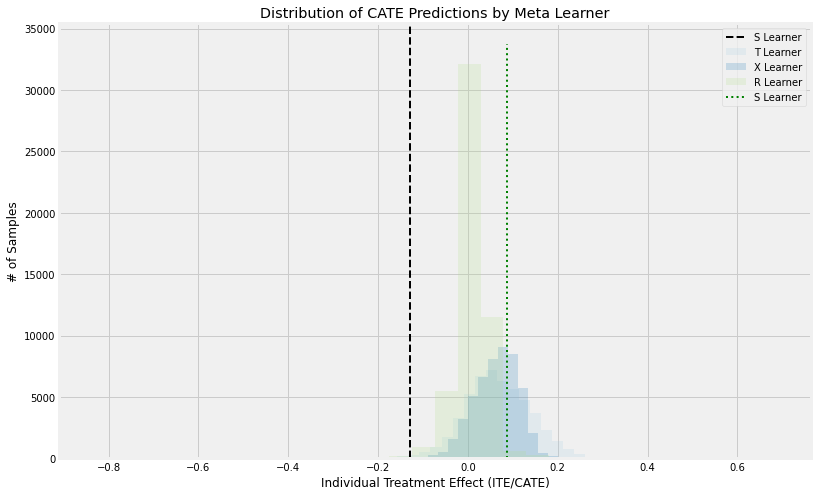

In [34]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
# Consider having this
plt.vlines(cate_t[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
# Or this
plt.axvline(x=-0.130 ,color="black", linestyle="--", label = "S Learner", linewidth=2)

plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

### Uplift Tree/Forest

In [35]:
# UpliftTreeClassifier
from causalml.dataset import make_uplift_classification

In [36]:
uplift_tree = UpliftTreeClassifier(control_name='control')
uplift_tree.fit(X=X,
                treatment=w_multi, 
                y=y)

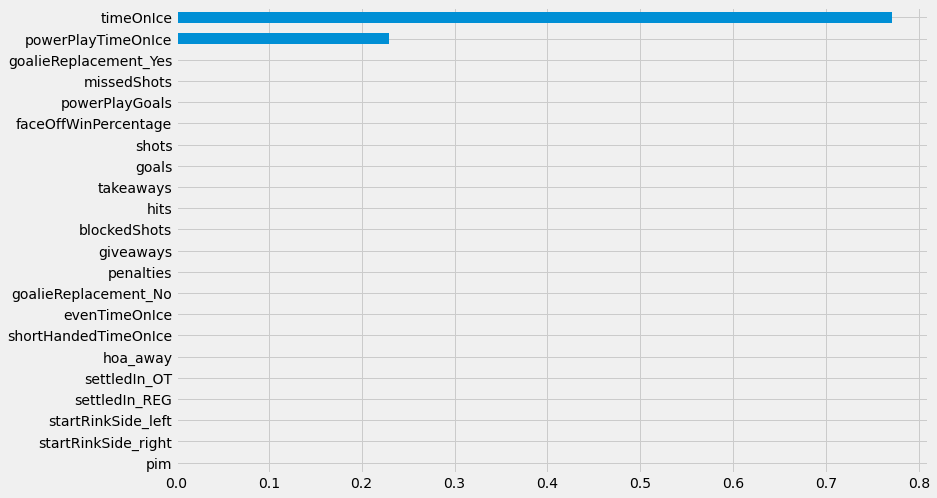

In [37]:
pd.Series(uplift_tree.feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(12,8))

In [38]:
# UpliftRandomForestClassifier
uplift_rf = UpliftRandomForestClassifier(control_name='control')

uplift_rf.fit(X=X.values,treatment=w_multi.values, y=y.values)

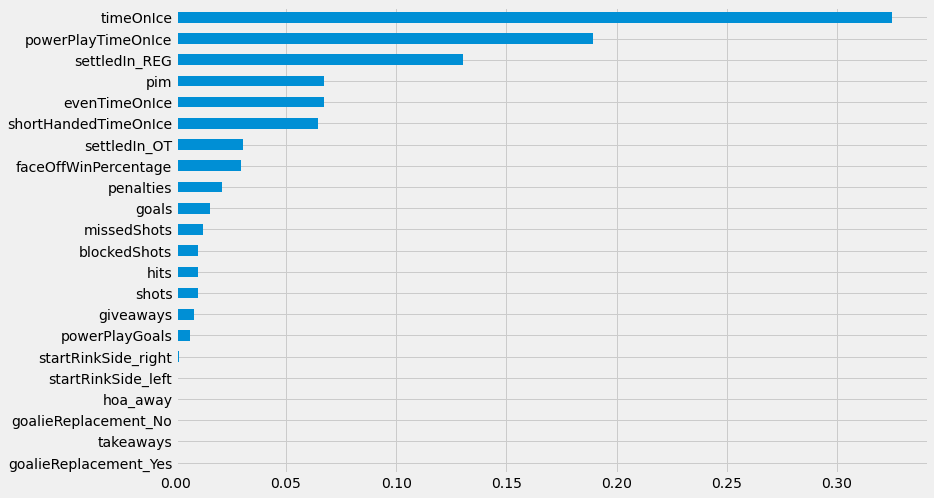

In [39]:
pd.Series(uplift_rf.feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(12,8))